--- Step 1: Upload Original Image ---
Please upload the image you want to inpaint.


Saving dip image.png to dip image.png

--- Step 2: Upload Mask Image ---
Please upload the mask (black area = inpaint, white area = keep).


Saving inpaint.jpeg to inpaint.jpeg
Both files uploaded. Image: dip image.png, Mask: inpaint.jpeg


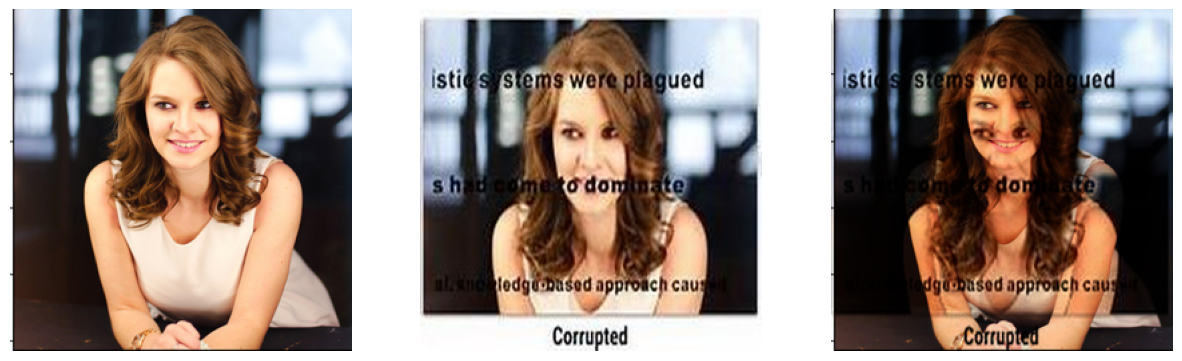

Number of parameters (U-Net): 2568739


  0%|          | 0/1500 [00:00<?, ?it/s]

Iteration 0 | Loss 0.053907


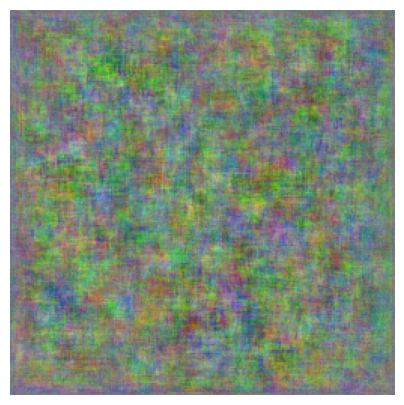

 20%|██        | 300/1500 [00:17<01:06, 18.02it/s]

Iteration 300 | Loss 0.000557


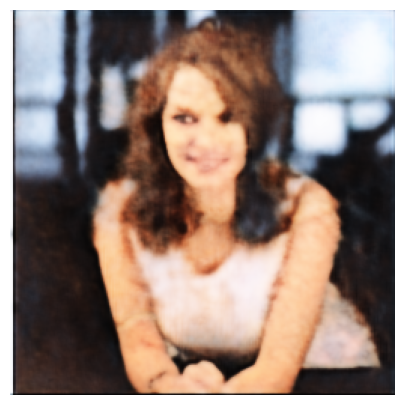

 40%|████      | 600/1500 [00:34<00:50, 17.71it/s]

Iteration 600 | Loss 0.000301


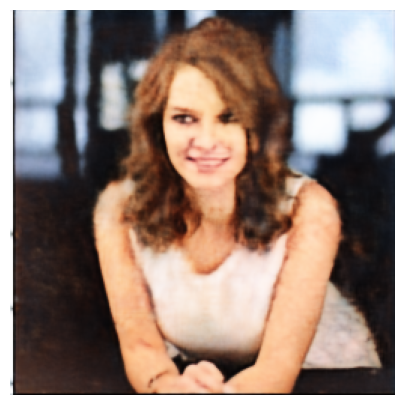

 60%|█████▉    | 899/1500 [00:51<00:34, 17.41it/s]

Iteration 900 | Loss 0.000153


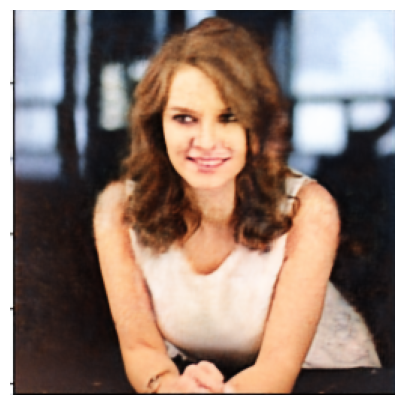

 80%|███████▉  | 1199/1500 [01:09<00:17, 17.11it/s]

Iteration 1200 | Loss 0.000129


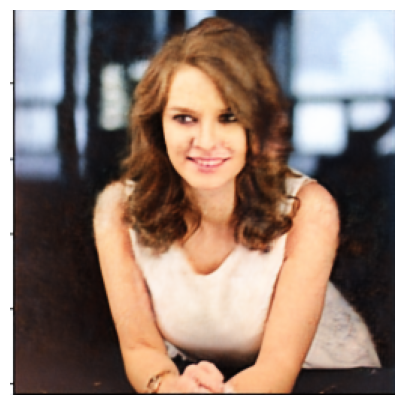

100%|██████████| 1500/1500 [01:27<00:00, 17.16it/s]

Iteration 1499 | Loss 0.000084

--- Final Result ---


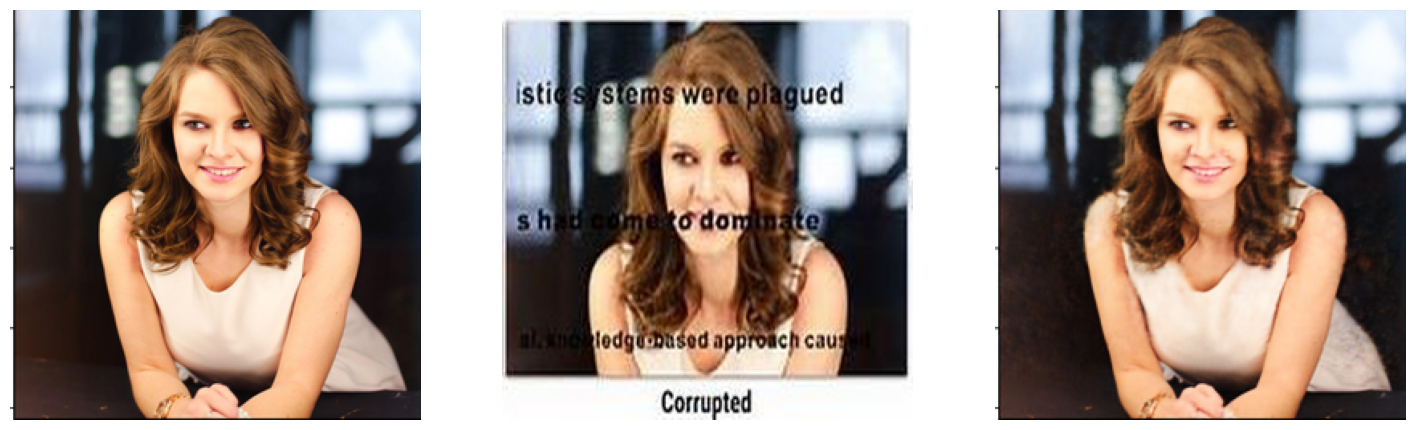

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Inpainting complete! Saved as inpainted_result.png and download initiated.


In [1]:

!pip install torch torchvision matplotlib numpy pillow tqdm --quiet

# Imports
import torch
import torch.nn as nn
import torch.optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from google.colab import files
import torch.nn.functional as F
import os
import sys

# Utilities (Standard functions for data handling - Unchanged)
def get_image(path, imsize=-1):
    resample_method = Image.Resampling.LANCZOS if hasattr(Image, 'Resampling') else Image.LANCZOS
    img = Image.open(path).convert('RGB')
    if imsize != -1:
        img = img.resize((imsize, imsize), resample_method)
    return img, pil_to_np(img)

def pil_to_np(img):
    return np.array(img).astype(np.float32).transpose(2,0,1)/255.

def np_to_torch(img_np):
    return torch.from_numpy(img_np)[None,:]

def torch_to_np(img_var):
    return img_var.detach().cpu().numpy()[0]

def plot_image_grid(images_np, factor=5):
    fig, axes = plt.subplots(1, len(images_np), figsize=(factor*len(images_np), factor))
    if len(images_np) == 1:
        axes = [axes]
    for ax, img in zip(axes, images_np):
        if img.ndim == 3:
            if img.shape[0] == 1:
                img = np.repeat(img, 3, axis=0)
            img = img.transpose(1,2,0)
        ax.imshow(np.clip(img,0,1))
        ax.axis('off')
    plt.show()

def get_noise(input_depth, input_type, spatial_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if input_type == 'noise':
        return torch.randn(1, input_depth, spatial_size[0], spatial_size[1]).to(device)
    elif input_type == 'meshgrid':
        return torch.zeros(1, input_depth, spatial_size[0], spatial_size[1]).to(device)

# U-Net Network (Structurally Correct Model - Unchanged)
class ConvBlock(nn.Module):
    def __init__(self, in_f, out_f, kernel_size, act=nn.LeakyReLU(0.2), use_batchnorm=True):
        super().__init__()
        layers = [
            nn.Conv2d(in_f, out_f, kernel_size, padding=kernel_size//2, bias=False),
            act
        ]
        if use_batchnorm:
            layers.insert(1, nn.BatchNorm2d(out_f))
        self.block = nn.Sequential(*layers)
    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self, input_depth=32, output_depth=3, num_channels=128, skip_channels=4):
        super().__init__()

        self.pool = nn.AvgPool2d(2,2)
        self.encoder1 = nn.Sequential(ConvBlock(input_depth, num_channels, 3), ConvBlock(num_channels, num_channels, 3))
        self.encoder2 = nn.Sequential(ConvBlock(num_channels, num_channels, 3), ConvBlock(num_channels, num_channels, 3))
        self.encoder3 = nn.Sequential(ConvBlock(num_channels, num_channels, 3), ConvBlock(num_channels, num_channels, 3))
        self.encoder4 = nn.Sequential(ConvBlock(num_channels, num_channels, 3), ConvBlock(num_channels, num_channels, 3))
        self.bottleneck = nn.Sequential(ConvBlock(num_channels, num_channels, 3), ConvBlock(num_channels, num_channels, 3))

        self.skip1 = ConvBlock(input_depth, skip_channels, 1, use_batchnorm=True)
        self.skip2 = ConvBlock(num_channels, skip_channels, 1, use_batchnorm=True)
        self.skip3 = ConvBlock(num_channels, skip_channels, 1, use_batchnorm=True)
        self.skip4 = ConvBlock(num_channels, skip_channels, 1, use_batchnorm=True)

        self.decoder4 = nn.Sequential(ConvBlock(num_channels + skip_channels, num_channels, 3), ConvBlock(num_channels, num_channels, 3))
        self.decoder3 = nn.Sequential(ConvBlock(num_channels + skip_channels, num_channels, 3), ConvBlock(num_channels, num_channels, 3))
        self.decoder2 = nn.Sequential(ConvBlock(num_channels + skip_channels, num_channels, 3), ConvBlock(num_channels, num_channels, 3))
        self.decoder1 = nn.Sequential(ConvBlock(num_channels + skip_channels, num_channels, 3), ConvBlock(num_channels, num_channels, 3))
        self.output = nn.Sequential(nn.Conv2d(num_channels, output_depth, 1), nn.Sigmoid())

    def forward(self, x):
        e1_feat = self.encoder1(x); s1 = self.skip1(x); p1 = self.pool(e1_feat)
        s2 = self.skip2(p1); e2_feat = self.encoder2(p1); p2 = self.pool(e2_feat)
        s3 = self.skip3(p2); e3_feat = self.encoder3(p2); p3 = self.pool(e3_feat)
        s4 = self.skip4(p3); e4_feat = self.encoder4(p3); p4 = self.pool(e4_feat)
        b = self.bottleneck(p4)

        d4_up = F.interpolate(b, scale_factor=2, mode='nearest'); d4_cat = torch.cat([d4_up, s4], dim=1); d4_out = self.decoder4(d4_cat)
        d3_up = F.interpolate(d4_out, scale_factor=2, mode='nearest'); d3_cat = torch.cat([d3_up, s3], dim=1); d3_out = self.decoder3(d3_cat)
        d2_up = F.interpolate(d3_out, scale_factor=2, mode='nearest'); d2_cat = torch.cat([d2_up, s2], dim=1); d2_out = self.decoder2(d2_cat)
        d1_up = F.interpolate(d2_out, scale_factor=2, mode='nearest'); d1_cat = torch.cat([d1_up, s1], dim=1); d1_out = self.decoder1(d1_cat)

        return self.output(d1_out)

# Upload image + mask (TWO SEPARATE STEPS)
print("--- Step 1: Upload Original Image ---")
print("Please upload the image you want to inpaint.")
uploaded_img = files.upload()
img_path = list(uploaded_img.keys())[0] if uploaded_img else None

print("\n--- Step 2: Upload Mask Image ---")
print("Please upload the mask (black area = inpaint, white area = keep).")
uploaded_mask = files.upload()
mask_path = list(uploaded_mask.keys())[0] if uploaded_mask else None

# Final check and fallback to default
if img_path is not None and mask_path is not None:
    print(f"Both files uploaded. Image: {img_path}, Mask: {mask_path}")
else:
    print("One or both uploads failed. Using default Kate image...")
    !wget -q https://raw.githubusercontent.com/DmitryUlyanov/deep-image-prior/master/data/inpainting/kate.png -O kate.png
    !wget -q https://raw.githubusercontent.com/DmitryUlyanov/deep-image-prior/master/data/inpainting/kate_mask.png -O kate_mask.png
    img_path = "kate.png"
    mask_path = "kate_mask.png"

# Load images (Resolution 256x256)
imsize = 256
try:
    img_pil, img_np = get_image(img_path, imsize)
    mask_pil, mask_np = get_image(mask_path, imsize)
except Exception as e:
    print(f"\n--- FATAL ERROR LOADING IMAGES ---")
    print(f"Failed to load files. Ensure both {img_path} and {mask_path} are valid images.")
    raise

plot_image_grid([img_np, mask_np, img_np*mask_np], factor=5)

# Convert to torch and ensure CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
img_var = np_to_torch(img_np).to(device).type(dtype)
mask_var = np_to_torch(mask_np).to(device).type(dtype)

# Network + parameters (MAXIMUM FEASIBLE QUALITY TWEAK)
input_depth = 32
net = UNet(input_depth=input_depth, output_depth=3).to(device).type(dtype)
net_input = get_noise(input_depth, 'noise', img_np.shape[1:])
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

# === MAXIMUM FEASIBLE QUALITY EXECUTION TUNING ===
LR = 0.01
num_iter = 1500     # TWEAK: Set to 1500 iterations for best DIP quality
show_every = 300    # TWEAK: Show progress every 300 steps
reg_noise_std = 1/50. # Maintained the lower noise for detail

optimizer = torch.optim.Adam(net.parameters(), lr=LR)
mse = torch.nn.MSELoss().type(dtype)

print("Number of parameters (U-Net):", sum(np.prod(list(p.size())) for p in net.parameters()))

#Optimization loop
for step in tqdm(range(num_iter)):
    optimizer.zero_grad()
    net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    out = net(net_input)
    loss = mse(out * mask_var, img_var * mask_var)
    loss.backward()
    optimizer.step()

    if step % show_every == 0 or step == num_iter - 1:
        print(f"Iteration {step} | Loss {loss.item():.6f}")
        if step % show_every == 0 and step < num_iter - 1:
            plot_image_grid([torch_to_np(out)], factor=5)

# Final output
print("\n--- Final Result ---")
out_np = torch_to_np(out)
if out_np.shape[0] == 1:
    out_np = np.repeat(out_np,3,axis=0)

# Plot final result (Original, Mask, Inpainted)
plot_image_grid([img_np, mask_np, out_np], factor=6)

# Save and Download the file
out_img = Image.fromarray((np.clip(out_np.transpose(1,2,0),0,1)*255).astype(np.uint8))
out_img.save("inpainted_result.png")
files.download("inpainted_result.png")
print(" Inpainting complete! Saved as inpainted_result.png and download initiated.")

In [4]:
#PSNR BM3D Denoie

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 862.0/862.0 kB 45.7 MB/s eta 0:00:00


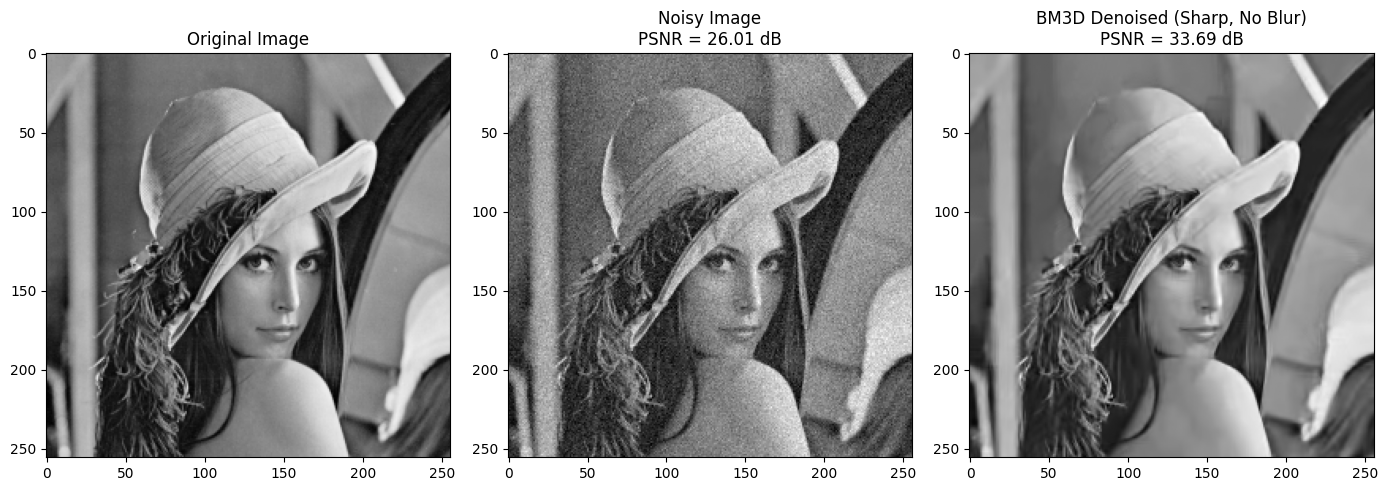

In [5]:
# Install BM3D dependency
!pip install bm3d scikit-image opencv-python matplotlib

# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, metrics, img_as_float
from bm3d import bm3d, BM3DProfile

# Step 1: Read image
url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg"
I = io.imread(url, as_gray=True)
I = cv2.resize(I, (256, 256))
I = img_as_float(I)

# Step 2: Add Gaussian noise
sigma = 0.05
noisyI = I + np.random.normal(0, sigma, I.shape)
noisyI = np.clip(noisyI, 0, 1)

# Step 3: PSNR of noisy image
psnr_noisy = metrics.peak_signal_noise_ratio(I, noisyI)

denoised_bm3d = bm3d(noisyI, sigma_psd=sigma, profile=BM3DProfile())

# Step 4: PSNR after denoising
psnr_bm3d = metrics.peak_signal_noise_ratio(I, denoised_bm3d)

# Step 5: Visualization
plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
plt.imshow(I, cmap='gray')
plt.title("Original Image")

plt.subplot(1,3,2)
plt.imshow(noisyI, cmap='gray')
plt.title(f"Noisy Image\nPSNR = {psnr_noisy:.2f} dB")

plt.subplot(1,3,3)
plt.imshow(denoised_bm3d, cmap='gray')
plt.title(f"BM3D Denoised (Sharp, No Blur)\nPSNR = {psnr_bm3d:.2f} dB")

plt.tight_layout()
plt.show()


In [6]:
#https://raw.githubusercontent.com/opencv/opencv/master/samples/data/baboon.jpg
#https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg
#https://raw.githubusercontent.com/opencv/opencv/master/samples/data/building.jpg
#https://raw.githubusercontent.com/opencv/opencv/master/samples/data/HappyFish.jpg
#https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left01.jpg
#https://raw.githubusercontent.com/opencv/opencv/master/samples/data/fruits.jpg
#https://raw.githubusercontent.com/opencv/opencv/master/samples/data/sudoku.png
#https://raw.githubusercontent.com/opencv/opencv/master/samples/data/smarties.png

In [7]:
#FOR RGB colour

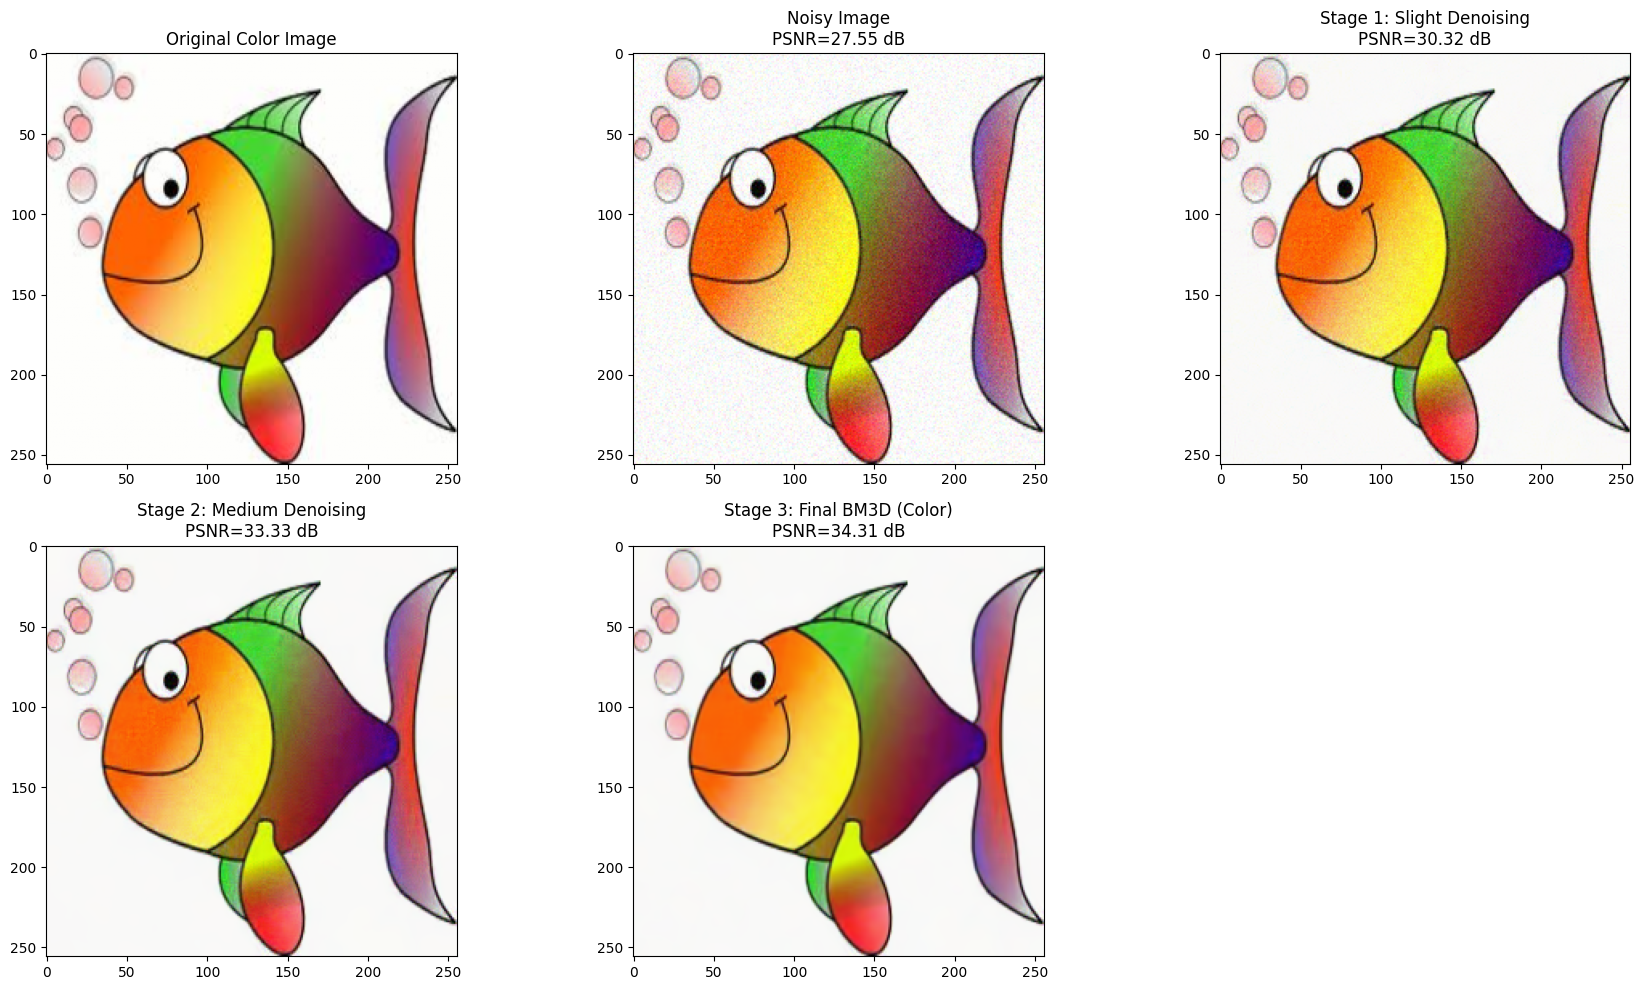

In [9]:
# Install dependencies
!pip install bm3d scikit-image opencv-python matplotlib

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, metrics, img_as_float
from bm3d import bm3d, BM3DProfile

# Step 1: Read COLOR image (no grayscale conversion!)
url = "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/HappyFish.jpg"
I = io.imread(url)                # load color image
I = cv2.resize(I, (256, 256))     # resize
I = img_as_float(I)               # convert to float [0,1]

# Step 2: Add Gaussian noise to all 3 channels
sigma = 0.05
noise = np.random.normal(0, sigma, I.shape)
noisyI = I + noise
noisyI = np.clip(noisyI, 0, 1)

# Step 3: Progressive COLOR denoising (simulate BM3D stages)
denoise_stage1 = bm3d(noisyI, sigma_psd=sigma*0.5, profile=BM3DProfile())   # light
denoise_stage2 = bm3d(noisyI, sigma_psd=sigma*0.75, profile=BM3DProfile())  # medium
denoise_stage3 = bm3d(noisyI, sigma_psd=sigma, profile=BM3DProfile())       # strong final

# Step 4: PSNR values
ps1 = metrics.peak_signal_noise_ratio(I, noisyI)
ps2 = metrics.peak_signal_noise_ratio(I, denoise_stage1)
ps3 = metrics.peak_signal_noise_ratio(I, denoise_stage2)
ps4 = metrics.peak_signal_noise_ratio(I, denoise_stage3)

# Step 5: Display results (COLOR)
plt.figure(figsize=(18,10))

plt.subplot(2,3,1)
plt.imshow(I)
plt.title("Original Color Image")

plt.subplot(2,3,2)
plt.imshow(noisyI)
plt.title(f"Noisy Image\nPSNR={ps1:.2f} dB")

plt.subplot(2,3,3)
plt.imshow(denoise_stage1)
plt.title(f"Stage 1: Slight Denoising\nPSNR={ps2:.2f} dB")

plt.subplot(2,3,4)
plt.imshow(denoise_stage2)
plt.title(f"Stage 2: Medium Denoising\nPSNR={ps3:.2f} dB")

plt.subplot(2,3,5)
plt.imshow(denoise_stage3)
plt.title(f"Stage 3: Final BM3D (Color)\nPSNR={ps4:.2f} dB")

plt.tight_layout()
plt.show()


In [10]:
#https://raw.githubusercontent.com/opencv/opencv/master/samples/data/baboon.jpg
#https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg
#https://raw.githubusercontent.com/opencv/opencv/master/samples/data/building.jpg
#https://raw.githubusercontent.com/opencv/opencv/master/samples/data/HappyFish.jpg
#https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left01.jpg
#https://raw.githubusercontent.com/opencv/opencv/master/samples/data/fruits.jpg
#https://raw.githubusercontent.com/opencv/opencv/master/samples/data/sudoku.png
#https://raw.githubusercontent.com/opencv/opencv/master/samples/data/smarties.png

Please upload an image (e.g., house.jpg)


Saving snail.png to snail.png
Uploaded file: snail.png
Using device: cuda
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 92.2MB/s]


High-quality optimization started...
Step [0/3000] | Total Loss: 8.759363
Step [300/3000] | Total Loss: 2.661515
Step [600/3000] | Total Loss: 2.598659
Step [900/3000] | Total Loss: 2.562786
Step [1200/3000] | Total Loss: 2.537570
Step [1500/3000] | Total Loss: 2.519184
Step [1800/3000] | Total Loss: 2.502266
Step [2100/3000] | Total Loss: 2.487921
Step [2400/3000] | Total Loss: 2.477108
Step [2700/3000] | Total Loss: 2.470195
Step [2999/3000] | Total Loss: 2.467834
Optimization complete!

========== METRIC RESULTS ==========
PSNR between Original & Reconstructed: 19.5555 dB
SSIM between Original & Reconstructed: 0.6577



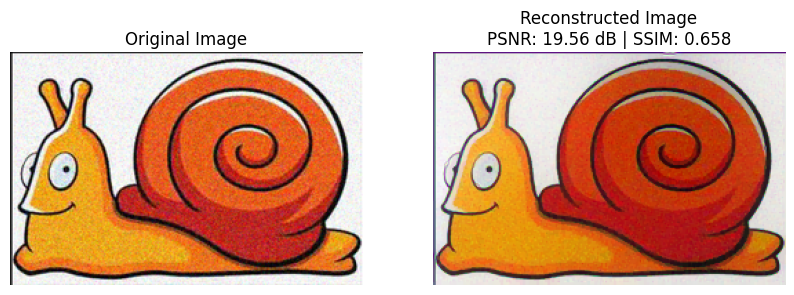

In [11]:
# High-Quality Feature Inversion using VGG16 + Regularization + PSNR/SSIM Metrics

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.models import VGG16_Weights
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric
import numpy as np
import math

# 1. Upload an image
print("Please upload an image (e.g., house.jpg)")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
print(f"Uploaded file: {image_path}")

# 2. Image loading & preprocessing
def load_image(path, max_size=256):
    image = Image.open(path).convert('RGB')
    size = max(image.size)
    if size > max_size:
        scale = max_size / size
        size = tuple((scale * s for s in image.size))
        image = image.resize((int(size[0]), int(size[1])))

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)

# 3. Feature Extractor
class FeatureExtractor(nn.Module):
    def __init__(self, model, layer_index):
        super().__init__()
        self.features = nn.Sequential(*list(model.features.children())[:layer_index])
    def forward(self, x):
        return self.features(x)

# 4. Load pretrained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

vgg = models.vgg16(weights=VGG16_Weights.DEFAULT).to(device).eval()
feature_extractor = FeatureExtractor(vgg, 7).to(device)

# 5. Load image and extract target features
original_image = load_image(image_path).to(device)
target_features = feature_extractor(original_image).detach()

# 6. Initialize generated image
generated_image = torch.randn_like(original_image, device=device) * 0.1 + original_image.mean()
generated_image.requires_grad_(True)

# 7. Loss
mse_loss = nn.MSELoss()

def total_variation_loss(img):
    diff_x = img[:, :, :, 1:] - img[:, :, :, :-1]
    diff_y = img[:, :, 1:, :] - img[:, :, :-1, :]
    return torch.sum(torch.abs(diff_x)) + torch.sum(torch.abs(diff_y))

# 8. Optimizer
optimizer = optim.Adam([generated_image], lr=0.12)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3000, eta_min=0.01)

# 9. Optimization loop
print("High-quality optimization started...")
num_steps = 3000
tv_weight = 5e-5

for step in range(num_steps):
    optimizer.zero_grad()

    gen_features = feature_extractor(generated_image)
    feature_loss = mse_loss(gen_features, target_features)
    tv_loss = total_variation_loss(generated_image) * tv_weight
    loss = feature_loss + tv_loss

    loss.backward()
    torch.nn.utils.clip_grad_norm_([generated_image], max_norm=2.0)
    optimizer.step()
    scheduler.step()

    if step % 300 == 0 or step == num_steps - 1:
        print(f"Step [{step}/{num_steps}] | Total Loss: {loss.item():.6f}")

print("Optimization complete!")

# 10. Denormalization for visualization AND metrics
def denorm(tensor):
    tensor = tensor.clone().detach().cpu().squeeze()
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    tensor = tensor + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    tensor = torch.clamp(tensor, 0, 1)
    return tensor.permute(1, 2, 0).numpy()

orig_np = denorm(original_image)
gen_np = denorm(generated_image)

# 11. Compute PSNR & SSIM metrics
psnr_value = psnr_metric(orig_np, gen_np, data_range=1.0)
ssim_value = ssim_metric(orig_np, gen_np, channel_axis=2, data_range=1.0)

print("\n========== METRIC RESULTS ==========")
print(f"PSNR between Original & Reconstructed: {psnr_value:.4f} dB")
print(f"SSIM between Original & Reconstructed: {ssim_value:.4f}")
print("====================================\n")

# 12. Display images
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(orig_np)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(gen_np)
plt.title(f"Reconstructed Image\nPSNR: {psnr_value:.2f} dB | SSIM: {ssim_value:.3f}")
plt.axis('off')

plt.show()


In [12]:
#EXACT DENOISING

Device: cuda
Upload your image


Saving pdenoise2.jpeg to pdenoise2.jpeg
Training...


  0%|          | 2/2000 [00:00<05:37,  5.92it/s]

Iter 0 | PSNR: 12.0984 | SSIM: 0.1009


  3%|▎         | 51/2000 [00:05<04:11,  7.73it/s]

Iter 50 | PSNR: 28.5018 | SSIM: 0.8594


  5%|▌         | 102/2000 [00:11<03:54,  8.10it/s]

Iter 100 | PSNR: 30.6908 | SSIM: 0.9066


  8%|▊         | 151/2000 [00:16<03:59,  7.71it/s]

Iter 150 | PSNR: 31.2743 | SSIM: 0.9180


 10%|█         | 202/2000 [00:21<03:38,  8.22it/s]

Iter 200 | PSNR: 31.4412 | SSIM: 0.9224


 13%|█▎        | 251/2000 [00:27<03:45,  7.74it/s]

Iter 250 | PSNR: 31.6894 | SSIM: 0.9265


 15%|█▌        | 301/2000 [00:32<03:39,  7.74it/s]

Iter 300 | PSNR: 31.8034 | SSIM: 0.9287


 18%|█▊        | 353/2000 [00:37<03:09,  8.71it/s]

Iter 350 | PSNR: 31.8178 | SSIM: 0.9300


 20%|██        | 403/2000 [00:43<03:03,  8.71it/s]

Iter 400 | PSNR: 32.0261 | SSIM: 0.9322


 23%|██▎       | 453/2000 [00:48<02:56,  8.74it/s]

Iter 450 | PSNR: 31.9820 | SSIM: 0.9324


 25%|██▌       | 503/2000 [00:53<02:50,  8.77it/s]

Iter 500 | PSNR: 32.0041 | SSIM: 0.9330


 28%|██▊       | 551/2000 [00:58<03:10,  7.59it/s]

Iter 550 | PSNR: 32.0093 | SSIM: 0.9334


 30%|███       | 603/2000 [01:03<02:38,  8.79it/s]

Iter 600 | PSNR: 32.0245 | SSIM: 0.9337


 33%|███▎      | 653/2000 [01:09<02:33,  8.77it/s]

Iter 650 | PSNR: 31.9644 | SSIM: 0.9337


 35%|███▌      | 703/2000 [01:14<02:28,  8.72it/s]

Iter 700 | PSNR: 32.1540 | SSIM: 0.9355


 38%|███▊      | 753/2000 [01:19<02:22,  8.77it/s]

Iter 750 | PSNR: 32.0000 | SSIM: 0.9343


 40%|████      | 803/2000 [01:24<02:17,  8.69it/s]

Iter 800 | PSNR: 31.9899 | SSIM: 0.9345


 43%|████▎     | 851/2000 [01:29<02:27,  7.77it/s]

Iter 850 | PSNR: 32.0170 | SSIM: 0.9348


 45%|████▌     | 901/2000 [01:35<02:24,  7.59it/s]

Iter 900 | PSNR: 32.0884 | SSIM: 0.9355


 48%|████▊     | 953/2000 [01:40<02:00,  8.68it/s]

Iter 950 | PSNR: 32.0827 | SSIM: 0.9356


 50%|█████     | 1001/2000 [01:45<02:09,  7.70it/s]

Iter 1000 | PSNR: 32.0589 | SSIM: 0.9358


 53%|█████▎    | 1053/2000 [01:51<01:49,  8.68it/s]

Iter 1050 | PSNR: 32.0807 | SSIM: 0.9359


 55%|█████▌    | 1101/2000 [01:56<01:56,  7.72it/s]

Iter 1100 | PSNR: 32.0845 | SSIM: 0.9358


 58%|█████▊    | 1153/2000 [02:01<01:37,  8.72it/s]

Iter 1150 | PSNR: 32.0784 | SSIM: 0.9361


 60%|██████    | 1203/2000 [02:07<01:32,  8.66it/s]

Iter 1200 | PSNR: 32.0472 | SSIM: 0.9357


 63%|██████▎   | 1253/2000 [02:12<01:25,  8.71it/s]

Iter 1250 | PSNR: 32.0814 | SSIM: 0.9362


 65%|██████▌   | 1303/2000 [02:17<01:19,  8.78it/s]

Iter 1300 | PSNR: 32.1187 | SSIM: 0.9364


 68%|██████▊   | 1351/2000 [02:22<01:24,  7.69it/s]

Iter 1350 | PSNR: 32.1020 | SSIM: 0.9366


 70%|███████   | 1403/2000 [02:27<01:08,  8.74it/s]

Iter 1400 | PSNR: 32.0976 | SSIM: 0.9364


 73%|███████▎  | 1453/2000 [02:33<01:02,  8.76it/s]

Iter 1450 | PSNR: 32.1111 | SSIM: 0.9366


 75%|███████▌  | 1503/2000 [02:38<00:56,  8.73it/s]

Iter 1500 | PSNR: 32.1057 | SSIM: 0.9367


 78%|███████▊  | 1553/2000 [02:43<00:51,  8.76it/s]

Iter 1550 | PSNR: 32.1074 | SSIM: 0.9368


 80%|████████  | 1603/2000 [02:48<00:45,  8.75it/s]

Iter 1600 | PSNR: 32.1193 | SSIM: 0.9368


 83%|████████▎ | 1651/2000 [02:53<00:45,  7.71it/s]

Iter 1650 | PSNR: 32.1402 | SSIM: 0.9370


 85%|████████▌ | 1703/2000 [02:59<00:35,  8.47it/s]

Iter 1700 | PSNR: 32.1519 | SSIM: 0.9372


 88%|████████▊ | 1753/2000 [03:04<00:28,  8.63it/s]

Iter 1750 | PSNR: 32.0957 | SSIM: 0.9367


 90%|█████████ | 1803/2000 [03:09<00:22,  8.66it/s]

Iter 1800 | PSNR: 32.0838 | SSIM: 0.9367


 93%|█████████▎| 1851/2000 [03:14<00:19,  7.79it/s]

Iter 1850 | PSNR: 32.0463 | SSIM: 0.9365


 95%|█████████▌| 1901/2000 [03:20<00:12,  7.78it/s]

Iter 1900 | PSNR: 32.0813 | SSIM: 0.9367


 98%|█████████▊| 1951/2000 [03:25<00:06,  7.80it/s]

Iter 1950 | PSNR: 32.0898 | SSIM: 0.9369


100%|██████████| 2000/2000 [03:30<00:00,  9.50it/s]


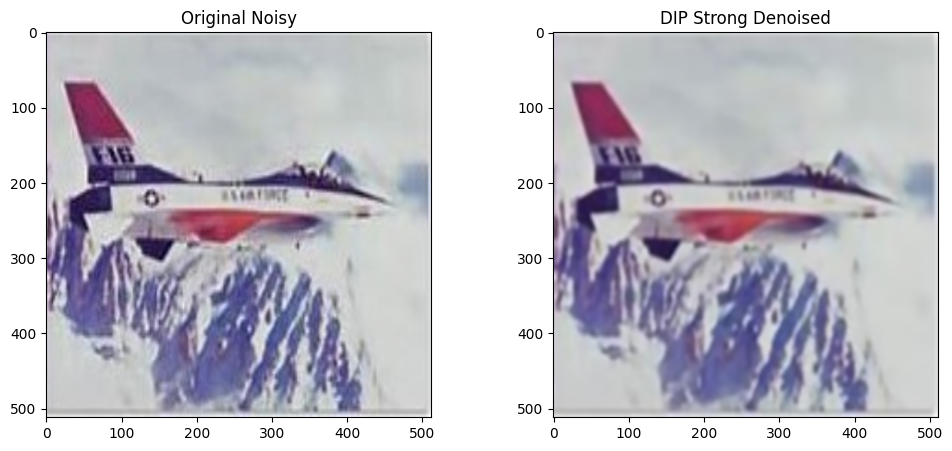

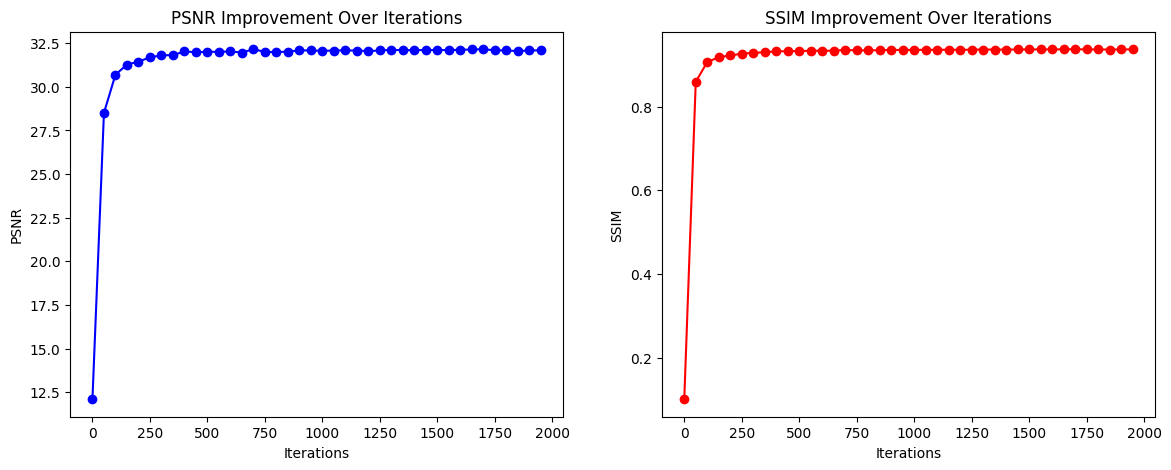

In [13]:
!pip install torch torchvision matplotlib numpy pillow tqdm scikit-image opencv-python --quiet

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import io, img_as_float
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import cv2
import torch.nn.functional as F
from google.colab import files

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------- UNET BUILDING BLOCKS ----------------
class ConvBlock(nn.Module):
    def __init__(self, in_f, out_f, act=nn.ReLU()):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_f, out_f, 3, padding=1),
            nn.BatchNorm2d(out_f),
            act,
            nn.Conv2d(out_f, out_f, 3, padding=1),
            nn.BatchNorm2d(out_f),
            act
        )

    def forward(self, x):
        return self.block(x)


class UNet(nn.Module):
    def __init__(self, input_depth=32, output_depth=3, num_channels=64):
        super().__init__()

        self.pool = nn.AvgPool2d(2, 2)

        self.enc1 = ConvBlock(input_depth, num_channels)
        self.enc2 = ConvBlock(num_channels, num_channels)
        self.enc3 = ConvBlock(num_channels, num_channels)
        self.enc4 = ConvBlock(num_channels, num_channels)

        self.bottleneck = ConvBlock(num_channels, num_channels)

        self.dec4 = ConvBlock(num_channels * 2, num_channels)
        self.dec3 = ConvBlock(num_channels * 2, num_channels)
        self.dec2 = ConvBlock(num_channels * 2, num_channels)
        self.dec1 = ConvBlock(num_channels * 2, num_channels)

        self.final = nn.Sequential(nn.Conv2d(num_channels, output_depth, 1), nn.Sigmoid())

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = F.interpolate(b, scale_factor=2)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = F.interpolate(d4, scale_factor=2)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = F.interpolate(d3, scale_factor=2)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = F.interpolate(d2, scale_factor=2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.final(d1)

# ---------------- HELPERS ----------------
def np_to_torch(img_np):
    return torch.from_numpy(img_np.transpose(2,0,1)[None]).float()

def torch_to_np(img_var):
    return img_var.detach().cpu().numpy()[0].transpose(1,2,0)

def get_noise(input_depth, spatial_size):
    return torch.randn(1, input_depth, spatial_size[0], spatial_size[1]).to(device)

def total_variation(x):
    return (torch.mean(torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:])) +
            torch.mean(torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :])))

# ---------------- UPLOAD IMAGE ----------------
print("Upload your image")
uploaded = files.upload()

img_path = list(uploaded.keys())[0]
I_noisy = io.imread(img_path)
I_noisy = cv2.resize(I_noisy, (512, 512))
I_noisy = img_as_float(I_noisy)

# FIX RGBA
if I_noisy.shape[2] == 4:
    print("RGBA detected — converting")
    tmp = (I_noisy * 255).astype(np.uint8)
    I_noisy = cv2.cvtColor(tmp, cv2.COLOR_RGBA2RGB) / 255.0

# STRONGER BLUR TARGET
I_target = cv2.GaussianBlur(I_noisy, (9,9), 2.0)

noisy_var = np_to_torch(I_noisy).to(device)
target_var = np_to_torch(I_target).to(device)

# ---------------- MODEL ----------------
net = UNet(input_depth=32, output_depth=3).to(device)
net_input = get_noise(32, I_noisy.shape[:2])

net_input_saved = net_input.detach().clone()

optimizer = optim.Adam(net.parameters(), lr=0.002)
mse = nn.MSELoss()

# ---------------- TRAINING SETTINGS ----------------
num_iter = 2000
reg_noise_std = 1 / 30.0
tv_weight = 0.01
early_stop_patience = 200
best_loss = 1e10
no_improve = 0

# tracking for accuracy plots
psnr_list = []
ssim_list = []
iteration_list = []

print("Training...")

# ---------------- TRAINING LOOP ----------------
for i in tqdm(range(num_iter)):

    optimizer.zero_grad()

    # noise regularization
    net_input = net_input_saved + reg_noise_std * torch.randn_like(net_input_saved)

    out = net(net_input)

    # compute loss
    loss_mse = mse(out, target_var)
    loss_tv = total_variation(out) * tv_weight
    loss = loss_mse + loss_tv

    loss.backward()
    optimizer.step()

    # --- compute PSNR & SSIM every 50 iterations ---
    if i % 50 == 0:
        out_np = torch_to_np(out)

        # PSNR
        p = psnr(I_noisy, out_np, data_range=1.0)

        # SSIM
        s = ssim(I_noisy, out_np, channel_axis=2, data_range=1.0)

        psnr_list.append(p)
        ssim_list.append(s)
        iteration_list.append(i)

        print(f"Iter {i} | PSNR: {p:.4f} | SSIM: {s:.4f}")

    # EARLY STOPPING
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_out = out.clone()
        no_improve = 0
    else:
        no_improve += 1
        if no_improve > early_stop_patience:
            print("Early stopping triggered.")
            break

# ---------------- FINAL OUTPUT ----------------
final_img = torch_to_np(best_out)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(I_noisy); plt.title("Original Noisy")
plt.subplot(1,2,2); plt.imshow(final_img); plt.title("DIP Strong Denoised")
plt.show()

# ---------------- PLOT PSNR & SSIM ----------------
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(iteration_list, psnr_list, 'b-o')
plt.title("PSNR Improvement Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("PSNR")

plt.subplot(1,2,2)
plt.plot(iteration_list, ssim_list, 'r-o')
plt.title("SSIM Improvement Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("SSIM")

plt.show()


In [14]:
#SUPER RESOLUTION

Running on: cuda
📁 Please upload an image...


Saving home.jpeg to home (4).jpeg

================ METRICS ================
Bicubic Upscale → PSNR: 45.52 dB | SSIM: 0.9919
Nearest Upscale → PSNR: 34.15 dB | SSIM: 0.9353



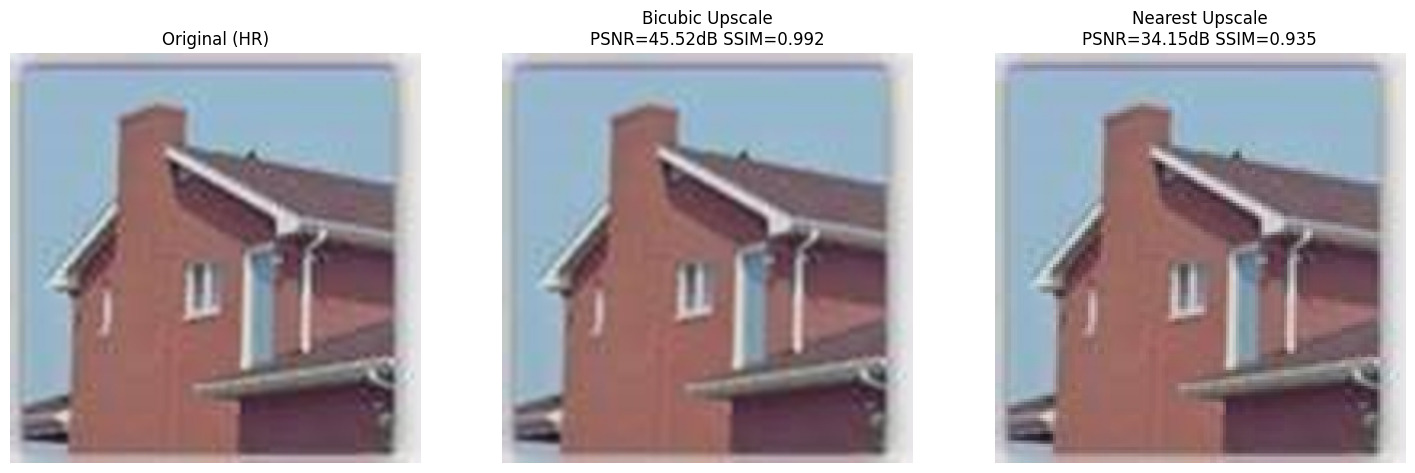

Saved as: bicubic_output.png and nearest_output.png


In [25]:
# =======================================
# Super-Resolution Demo + PSNR/SSIM Metrics
# =======================================
import io
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# =======================================
# Colab Upload
# =======================================
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# =======================================
# Device Setup
# =======================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

# =======================================
# Utility Functions
# =======================================
def pil_to_np(img_pil):
    img_np = np.array(img_pil).astype(np.float32) / 255.
    if img_np.ndim == 2:
        img_np = img_np[None, ...]
    else:
        img_np = img_np.transpose(2, 0, 1)
    return img_np

def to_gray(img):
    """Converts CHW numpy to grayscale for PSNR/SSIM."""
    if img.shape[0] == 3:
        img = np.mean(img, axis=0)
    return img

def plot_image_grid(images_np, titles=None, factor=3):
    fig, axes = plt.subplots(1, len(images_np), figsize=(len(images_np) * factor, factor))
    if len(images_np) == 1:
        axes = [axes]
    for i, (ax, im) in enumerate(zip(axes, images_np)):
        im = np.clip(im, 0, 1)
        if im.shape[0] == 1:
            im = im[0]
        else:
            im = im.transpose(1, 2, 0)
        ax.imshow(im)
        ax.axis('off')
        if titles:
            ax.set_title(titles[i])
    plt.show()

# =======================================
# Upload Image
# =======================================
if IN_COLAB:
    print("📁 Please upload an image...")
    uploaded = files.upload()
    file_name = next(iter(uploaded))
else:
    file_name = input("Enter image path (e.g., ./your_image.jpg): ")

# Load HR image and resize
img_HR_pil = Image.open(file_name).convert("RGB").resize((512, 512), Image.LANCZOS)
img_HR_np = pil_to_np(img_HR_pil)

# =======================================
# Create Low-Resolution & Upscaled Versions
# =======================================
down_factor = 4

# Step 1: Downsample
img_LR_pil = img_HR_pil.resize(
    (img_HR_pil.size[0] // down_factor, img_HR_pil.size[1] // down_factor),
    Image.BICUBIC
)

# Step 2: Upscale using different methods
bicubic_up = img_LR_pil.resize(img_HR_pil.size, Image.BICUBIC)
nearest_up = img_LR_pil.resize(img_HR_pil.size, Image.NEAREST)

# Convert to numpy CHW
bicubic_np = pil_to_np(bicubic_up)
nearest_np = pil_to_np(nearest_up)

# =======================================
# Compute PSNR & SSIM Metrics
# =======================================
HR_gray = to_gray(img_HR_np)
bicubic_gray = to_gray(bicubic_np)
nearest_gray = to_gray(nearest_np)

psnr_bicubic = psnr(HR_gray, bicubic_gray, data_range=1.0)
ssim_bicubic = ssim(HR_gray, bicubic_gray, data_range=1.0)

psnr_nearest = psnr(HR_gray, nearest_gray, data_range=1.0)
ssim_nearest = ssim(HR_gray, nearest_gray, data_range=1.0)

print("\n================ METRICS ================")
print(f"Bicubic Upscale → PSNR: {psnr_bicubic:.2f} dB | SSIM: {ssim_bicubic:.4f}")
print(f"Nearest Upscale → PSNR: {psnr_nearest:.2f} dB | SSIM: {ssim_nearest:.4f}")
print("========================================\n")

# =======================================
# Show Images
# =======================================
plot_image_grid(
    [img_HR_np, bicubic_np, nearest_np],
    titles=[
        'Original (HR)',
        f'Bicubic Upscale\nPSNR={psnr_bicubic:.2f}dB SSIM={ssim_bicubic:.3f}',
        f'Nearest Upscale\nPSNR={psnr_nearest:.2f}dB SSIM={ssim_nearest:.3f}',
    ],
    factor=6
)

# =======================================
# Save Outputs
# =======================================
cv2.imwrite("bicubic_output.png", cv2.cvtColor(np.array(bicubic_up), cv2.COLOR_RGB2BGR))
cv2.imwrite("nearest_output.png", cv2.cvtColor(np.array(nearest_up), cv2.COLOR_RGB2BGR))

print("Saved as: bicubic_output.png and nearest_output.png")


In [27]:
!pip install --quiet torch torchvision matplotlib pillow scikit-image tqdm

DEVICE = cuda
Upload ONE image (small images => treated as LR input).


Saving home.jpeg to home (15).jpeg
Detected small image (114x109) — treating as LR input.
LR padded: 128x112 (orig 114x109) -> HR target: 512x448
Training DIP SR... (this can take a while; reduce NUM_ITERS for quick tests)
Iter 0/1200 | loss 0.068152 | recent PSNR 14.775714899780635
Iter 200/1200 | loss 0.050047 | recent PSNR 16.33232598912195
Iter 400/1200 | loss 0.014711 | recent PSNR 29.13128301872186
Iter 600/1200 | loss 0.007703 | recent PSNR 34.49531658206119
Iter 800/1200 | loss 0.005765 | recent PSNR 35.63633192345202
Iter 1000/1200 | loss 0.004779 | recent PSNR 36.738543601468635


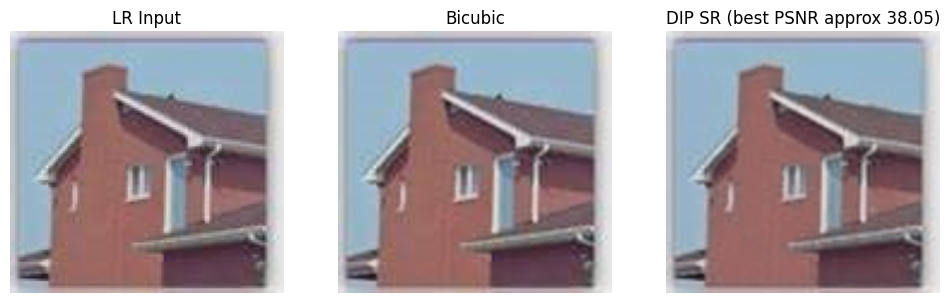

Saved DIP SR best output to dip_sr_best.png


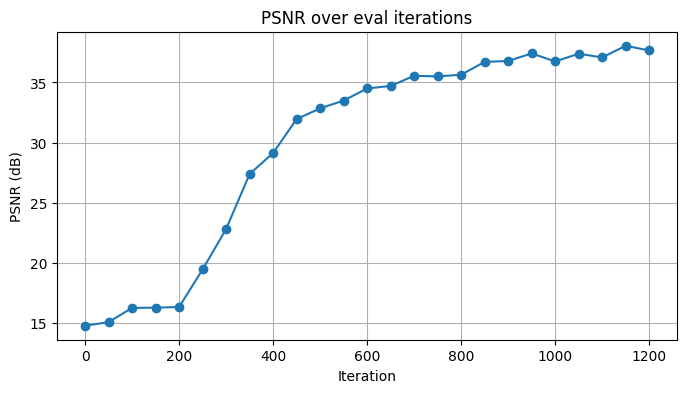

Done — DIP SR complete. Now go sleep 😴


In [37]:
import os, io, time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import trange
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from skimage.metrics import peak_signal_noise_ratio as sk_psnr, structural_similarity as sk_ssim
from torchvision import models
import cv2

# ----------------- Settings -----------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE =", DEVICE)

# DIP hyperparameters - tweak if desired
SCALE = 4                 # upscaling factor
INPUT_DEPTH = 32          # noise channels
BASE_FILTERS = 32
DEPTH = 4                 # UNet depth -> padding multiple = 2**DEPTH
NUM_ITERS = 1200
LR = 1e-3
TV_WEIGHT = 1e-6
VGG_WEIGHT = 0.01
EDGE_WEIGHT = 0.3
EVAL_EVERY = 50
UNSHARP_AMOUNT = 0.6      # 0 = no sharpening, higher -> stronger
SAVE_OUT = "dip_sr_best.png"

# ----------------- Utilities -----------------
def pil_to_np_chw(img_pil):
    arr = np.array(img_pil).astype(np.float32) / 255.0
    if arr.ndim == 2:
        arr = np.stack([arr,arr,arr], axis=-1)
    return arr.transpose(2,0,1)  # CHW

def np_chw_to_pil(arr_chw):
    arr = np.clip(arr_chw.transpose(1,2,0), 0, 1)
    return Image.fromarray((arr*255).astype(np.uint8))

def to_tensor(chw):
    return torch.from_numpy(chw).unsqueeze(0).float().to(DEVICE)  # [1,C,H,W]

def from_tensor(t):
    return t.detach().cpu().squeeze(0).numpy()  # CHW

def compute_metrics(gt_chw, pr_chw):
    # PSNR/SSIM on grayscale (robust)
    gt_gray = np.mean(gt_chw, axis=0)
    pr_gray = np.mean(pr_chw, axis=0)
    return sk_psnr(gt_gray, pr_gray, data_range=1.0), sk_ssim(gt_gray, pr_gray, data_range=1.0)

def tv_loss(x):
    return (torch.abs(x[:,:,1:,:] - x[:,:,:-1,:]).mean() +
            torch.abs(x[:,:,:,1:] - x[:,:,:,:-1]).mean())

# ----------------- Sobel edges -----------------
def sobel_edges(t):
    # expects [B,3,H,W] in DEVICE
    gray = 0.2989*t[:,0:1,:,:] + 0.5870*t[:,1:2,:,:] + 0.1140*t[:,2:3,:,:]
    kx = torch.tensor([[[-1.,0.,1.],[-2.,0.,2.],[-1.,0.,1.]]], device=DEVICE).unsqueeze(0) / 4.0
    ky = torch.tensor([[[-1.,-2.,-1.],[0.,0.,0.],[1.,2.,1.]]], device=DEVICE).unsqueeze(0) / 4.0
    gx = F.conv2d(gray, kx, padding=1)
    gy = F.conv2d(gray, ky, padding=1)
    return torch.sqrt(gx*gx + gy*gy + 1e-6)

# ----------------- VGG perceptual (device-safe) -----------------
class VGGPerceptual(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features[:16]
        self.vgg = vgg.to(DEVICE).eval()
        for p in self.vgg.parameters():
            p.requires_grad = False
        self.register_buffer("mean", torch.tensor([0.485,0.456,0.406]).view(1,3,1,1).to(DEVICE))
        self.register_buffer("std",  torch.tensor([0.229,0.224,0.225]).view(1,3,1,1).to(DEVICE))
    def forward(self, x, y):
        # x,y in [0,1] range on DEVICE
        x_n = (x - self.mean) / self.std
        y_n = (y - self.mean) / self.std
        fx = self.vgg(x_n)
        fy = self.vgg(y_n)
        return F.mse_loss(fx, fy)

VGG = VGGPerceptual()

# ----------------- Adaptive U-Net (stable) -----------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class AdaptiveUNet(nn.Module):
    def __init__(self, in_channels, out_channels=3, base_filters=BASE_FILTERS, depth=DEPTH):
        super().__init__()
        self.depth = depth
        self.downs = nn.ModuleList()
        self.pools = nn.ModuleList()
        enc_ch = []
        ch = in_channels
        for i in range(depth):
            out_ch = base_filters * (2 ** i)
            self.downs.append(DoubleConv(ch, out_ch))
            self.pools.append(nn.AvgPool2d(2))
            enc_ch.append(out_ch)
            ch = out_ch
        self.bottleneck = DoubleConv(ch, ch*2)
        ch = ch*2
        self.up_transposes = nn.ModuleList()
        self.decoder_convs = nn.ModuleList()
        for enc in reversed(enc_ch):
            self.up_transposes.append(nn.ConvTranspose2d(ch, enc, 2, stride=2))
            self.decoder_convs.append(DoubleConv(enc*2, enc))
            ch = enc
        self.final_conv = nn.Conv2d(ch, out_channels, 1)
    def forward(self, x):
        skips = []
        out = x
        for enc, pool in zip(self.downs, self.pools):
            out = enc(out)
            skips.append(out)
            out = pool(out)
        out = self.bottleneck(out)
        for up, dec in zip(self.up_transposes, self.decoder_convs):
            out = up(out)
            skip = skips.pop()
            # fix spatial mismatch by interpolation if needed
            if out.shape[-2:] != skip.shape[-2:]:
                out = F.interpolate(out, size=skip.shape[-2:], mode='bilinear', align_corners=False)
            out = torch.cat([skip, out], dim=1)
            out = dec(out)
        out = self.final_conv(out)
        return torch.sigmoid(out)

# ----------------- Padding helpers -----------------
def pad_to_multiple(img_pil, multiple):
    """Pad by reflecting borders to make width/height divisible by multiple.
       Returns padded_image, (orig_w, orig_h, padded_w, padded_h)
    """
    w,h = img_pil.size
    new_w = ((w + multiple - 1) // multiple) * multiple
    new_h = ((h + multiple - 1) // multiple) * multiple
    pad_w = new_w - w
    pad_h = new_h - h
    if pad_w == 0 and pad_h == 0:
        return img_pil, (w,h,new_w,new_h)
    # pad right & bottom using reflect to avoid border artifacts
    arr = np.array(img_pil).astype(np.uint8)
    padded = cv2.copyMakeBorder(arr, 0, pad_h, 0, pad_w, borderType=cv2.BORDER_REFLECT)
    return Image.fromarray(padded), (w,h,new_w,new_h)

def crop_chw_to_size(chw, target_w, target_h):
    """chw: numpy CHW, crop width (x) and height (y) to target (target_w, target_h)"""
    # chw shape (C, H, W)
    C, H, W = chw.shape
    return chw[:, :target_h, :target_w]

# ----------------- DIP SR main (with padding fix) -----------------
def dip_super_resolve(LR_pil):
    # pad LR so its dims divisible by 2**DEPTH
    multiple = 2 ** DEPTH
    LR_padded, (orig_w, orig_h, padded_w, padded_h) = pad_to_multiple(LR_pil, multiple)
    lr_w, lr_h = LR_padded.size
    hr_w, hr_h = lr_w * SCALE, lr_h * SCALE

    print(f"LR padded: {lr_w}x{lr_h} (orig {orig_w}x{orig_h}) -> HR target: {hr_w}x{hr_h}")

    # prepare tensors (all on DEVICE)
    lr_chw = pil_to_np_chw(LR_padded)
    lr_t = to_tensor(lr_chw)  # [1,3,lr_h,lr_w]

    # bicubic upsample target (used for VGG/edge when no GT)
    bic_up_pil = LR_padded.resize((hr_w, hr_h), Image.BICUBIC)
    bic_chw = pil_to_np_chw(bic_up_pil)
    bic_t = to_tensor(bic_chw)

    # build network and noise input (HR-size)
    net = AdaptiveUNet(in_channels=INPUT_DEPTH, out_channels=3, base_filters=BASE_FILTERS, depth=DEPTH).to(DEVICE)
    z = (torch.randn(1, INPUT_DEPTH, hr_h, hr_w, device=DEVICE) * 0.1).clamp(-1,1)

    opt = optim.Adam(net.parameters(), lr=LR)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=NUM_ITERS, eta_min=LR*0.1)

    best_psnr = -1e9
    best_img = None
    loss_hist = []
    psnr_list = []
    iters_list = []

    print("Training DIP SR... (this can take a while; reduce NUM_ITERS for quick tests)")

    for i in range(NUM_ITERS):
        opt.zero_grad()
        # small jitter noise on z helps avoid overfitting too early
        z_j = z + (torch.randn_like(z) * 0.02)
        out = net(z_j)  # [1,3,hr_h,hr_w] in [0,1]
        # downsample to lr padded size
        out_down = F.interpolate(out, size=(lr_h, lr_w), mode='bilinear', align_corners=False)

        # losses
        loss_mse = F.mse_loss(out_down, lr_t)
        loss_tv = TV_WEIGHT * tv_loss(out)
        loss_vgg = VGG_WEIGHT * VGG(out, bic_t)
        loss_edge = EDGE_WEIGHT * F.mse_loss(sobel_edges(out), sobel_edges(bic_t))

        loss = loss_mse + loss_tv + loss_vgg + loss_edge
        loss.backward()
        opt.step()
        scheduler.step()

        loss_hist.append(loss.item())

        if (i % EVAL_EVERY == 0) or (i == NUM_ITERS - 1):
            with torch.no_grad():
                out_np = np.clip(from_tensor(out), 0.0, 1.0)  # CHW
                # evaluate PSNR vs bicubic (or GT if you modify to pass GT)
                psnr_v, ssim_v = compute_metrics(bic_chw, out_np)
                psnr_list.append(psnr_v)
                iters_list.append(i)
                if psnr_v > best_psnr:
                    best_psnr = psnr_v
                    best_img = out_np.copy()
        # occasional status
        if i % max(1, NUM_ITERS//6) == 0:
            recent_psnr = psnr_list[-1] if psnr_list else None
            print(f"Iter {i}/{NUM_ITERS} | loss {loss.item():.6f} | recent PSNR {recent_psnr}")

    # if no best found (very unlikely), compute final
    if best_img is None:
        with torch.no_grad():
            best_img = np.clip(from_tensor(net(z)), 0.0, 1.0)

    # crop best_img back to original HR size (orig_w * SCALE, orig_h * SCALE)
    target_w = orig_w * SCALE
    target_h = orig_h * SCALE
    best_cropped = crop_chw_to_size(best_img, target_w, target_h)

    # optional unsharp mask to increase perceived sharpness
    def unsharp_chw(chw, amount=UNSHARP_AMOUNT, radius=1):
        # chw in [0,1], shape C,H,W
        img = (chw.transpose(1,2,0) * 255.0).astype(np.uint8)
        blurred = cv2.GaussianBlur(img, (0,0), sigmaX=radius, sigmaY=radius)
        sharp = cv2.addWeighted(img.astype(np.float32), 1.0 + amount, blurred.astype(np.float32), -amount, 0.0)
        sharp = np.clip(sharp, 0, 255).astype(np.uint8)
        return (sharp.astype(np.float32) / 255.0).transpose(2,0,1)

    try:
        final_img = unsharp_chw(best_cropped, amount=UNSHARP_AMOUNT, radius=1)
    except Exception:
        final_img = best_cropped

    logs = {
        'loss': loss_hist,
        'psnr': psnr_list,
        'iters': iters_list,
        'best_psnr': best_psnr
    }
    return final_img, logs

# ----------------- Main: upload & run -----------------
print("Upload ONE image (small images => treated as LR input).")
try:
    from google.colab import files as _files
    uploaded = _files.upload()
    if len(uploaded) == 0:
        raise RuntimeError("No file uploaded.")
    fname = list(uploaded.keys())[0]
    img = Image.open(fname).convert('RGB')
except Exception:
    fname = input("Enter local image path: ")
    img = Image.open(fname).convert('RGB')

# auto-detect: small images are likely LR; threshold (changeable)
thr = 128
w,h = img.size
if max(w,h) <= thr:
    print(f"Detected small image ({w}x{h}) — treating as LR input.")
    LR_pil = img
    best_out_chw, logs = dip_super_resolve(LR_pil)
    # bicubic baseline for visual comparison
    bic_up = LR_pil.resize((LR_pil.size[0]*SCALE, LR_pil.size[1]*SCALE), Image.BICUBIC)
    bic_pil = bic_up
    dip_pil = np_chw_to_pil(best_out_chw)
    # display
    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1); plt.imshow(LR_pil); plt.title("LR Input"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(bic_pil); plt.title("Bicubic"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(dip_pil); plt.title(f"DIP SR (best PSNR approx {logs['best_psnr']:.2f})"); plt.axis('off')
    plt.show()
    dip_pil.save(SAVE_OUT)
    print("Saved DIP SR best output to", SAVE_OUT)
    # PSNR curve
    if logs['psnr']:
        plt.figure(figsize=(8,4))
        plt.plot(logs['iters'], logs['psnr'], '-o')
        plt.title("PSNR over eval iterations")
        plt.xlabel("Iteration")
        plt.ylabel("PSNR (dB)")
        plt.grid(True)
        plt.show()
else:
    print(f"Detected large image ({w}x{h}) — treating as HR GT: creating LR -> running DIP.")
    lr_w = max(8, w // SCALE)
    lr_h = max(8, h // SCALE)
    LR_pil = img.resize((lr_w, lr_h), Image.BICUBIC)
    HR_pil = img.resize((lr_w * SCALE, lr_h * SCALE), Image.LANCZOS)
    best_out_chw, logs = dip_super_resolve(LR_pil)
    dip_pil = np_chw_to_pil(best_out_chw)
    bic_pil = LR_pil.resize((lr_w * SCALE, lr_h * SCALE), Image.BICUBIC)
    hr_chw = pil_to_np_chw(HR_pil)
    bic_chw = pil_to_np_chw(bic_pil)
    dip_chw = best_out_chw
    bic_psnr, bic_ssim = compute_metrics(hr_chw, bic_chw)
    dip_psnr, dip_ssim = compute_metrics(hr_chw, dip_chw)
    print("\nFINAL METRICS:")
    print(f" Bicubic -> PSNR: {bic_psnr:.4f} dB | SSIM: {bic_ssim:.4f}")
    print(f" DIP (best) -> PSNR: {dip_psnr:.4f} dB | SSIM: {dip_ssim:.4f}")
    plt.figure(figsize=(14,6))
    plt.subplot(1,3,1); plt.imshow(HR_pil); plt.title("HR (GT)"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(bic_pil); plt.title(f"Bicubic\nPSNR={bic_psnr:.2f}dB"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(dip_pil); plt.title(f"DIP SR (best)\nPSNR={dip_psnr:.2f}dB"); plt.axis('off')
    plt.show()
    # plots
    if logs['loss']:
        plt.figure(figsize=(8,4)); plt.plot(logs['loss']); plt.title("Training Loss"); plt.xlabel("Iteration"); plt.grid(True); plt.show()
    if logs['psnr']:
        plt.figure(figsize=(8,4)); plt.plot(logs['iters'], logs['psnr'], '-o'); plt.title("PSNR over eval iterations"); plt.xlabel("Iteration"); plt.ylabel("PSNR"); plt.grid(True); plt.show()
    dip_pil.save(SAVE_OUT)
    print("Saved DIP SR best output to", SAVE_OUT)

print("Done — DIP SR complete. Now go sleep 😴")


In [20]:
#MULTIMODAL

Device: cuda
Upload Modality A (target)


Saving MRI Scan.jpeg to MRI Scan.jpeg
Upload Modality B (aux guidance)


Saving CT Scan.jpeg to CT Scan.jpeg


  0%|          | 4/1500 [00:00<02:03, 12.11it/s]

Iter 0/1500 | PSNR: 8.93


  7%|▋         | 104/1500 [00:03<00:49, 28.36it/s]

Iter 100/1500 | PSNR: 20.96


 14%|█▎        | 206/1500 [00:07<00:41, 31.41it/s]

Iter 200/1500 | PSNR: 31.37


 20%|██        | 306/1500 [00:10<00:38, 31.38it/s]

Iter 300/1500 | PSNR: 36.80


 27%|██▋       | 406/1500 [00:13<00:35, 31.21it/s]

Iter 400/1500 | PSNR: 39.56


 34%|███▎      | 505/1500 [00:16<00:32, 30.94it/s]

Iter 500/1500 | PSNR: 41.76


 40%|████      | 605/1500 [00:19<00:28, 31.32it/s]

Iter 600/1500 | PSNR: 43.02


 47%|████▋     | 705/1500 [00:23<00:25, 31.58it/s]

Iter 700/1500 | PSNR: 44.06


 54%|█████▎    | 805/1500 [00:26<00:23, 30.17it/s]

Iter 800/1500 | PSNR: 43.93


 60%|██████    | 907/1500 [00:29<00:18, 32.11it/s]

Iter 900/1500 | PSNR: 44.46


 67%|██████▋   | 1007/1500 [00:32<00:15, 31.91it/s]

Iter 1000/1500 | PSNR: 44.92


 74%|███████▍  | 1107/1500 [00:35<00:12, 31.71it/s]

Iter 1100/1500 | PSNR: 45.06


 80%|████████  | 1202/1500 [00:39<00:22, 13.10it/s]

Iter 1200/1500 | PSNR: 45.39


 87%|████████▋ | 1304/1500 [00:42<00:06, 31.91it/s]

Iter 1300/1500 | PSNR: 45.78


 94%|█████████▎| 1404/1500 [00:46<00:03, 31.69it/s]

Iter 1400/1500 | PSNR: 45.90


100%|██████████| 1500/1500 [00:49<00:00, 30.33it/s]



=========== FINAL METRICS AFTER DIP ===========
PSNR (A → DIP): 46.19 dB
SSIM (A → DIP): 0.9872

----- IMPROVEMENT SUMMARY -----
PSNR Improvement: 35.49 dB
SSIM Improvement: 0.6889



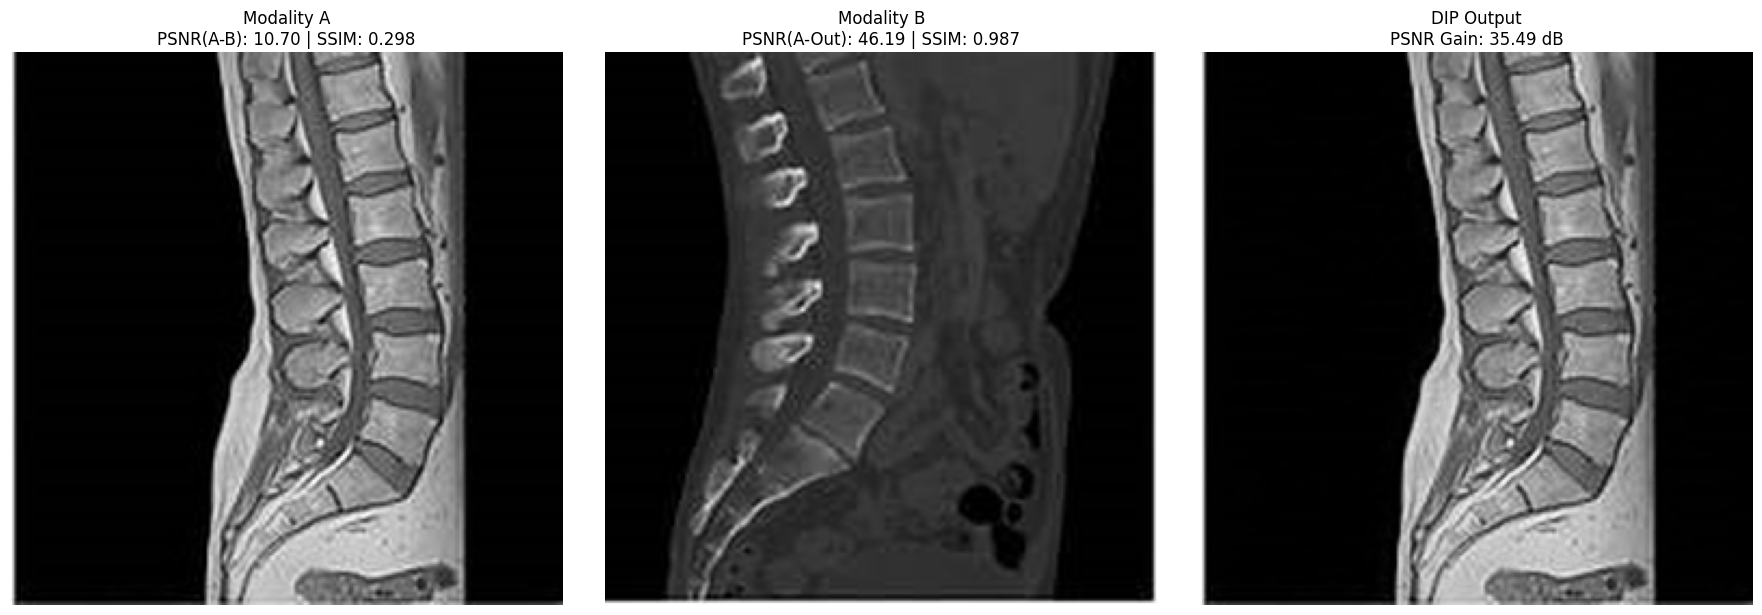

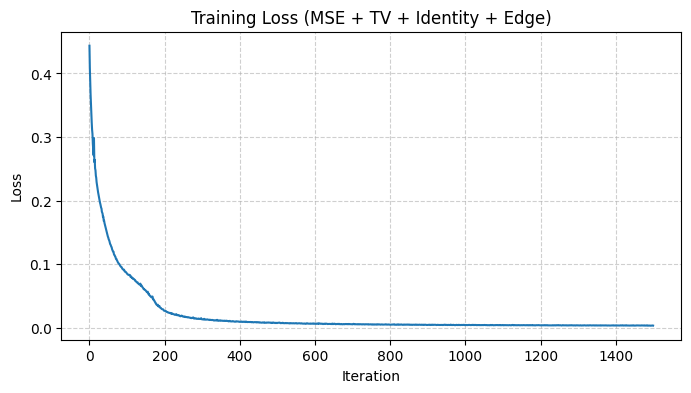

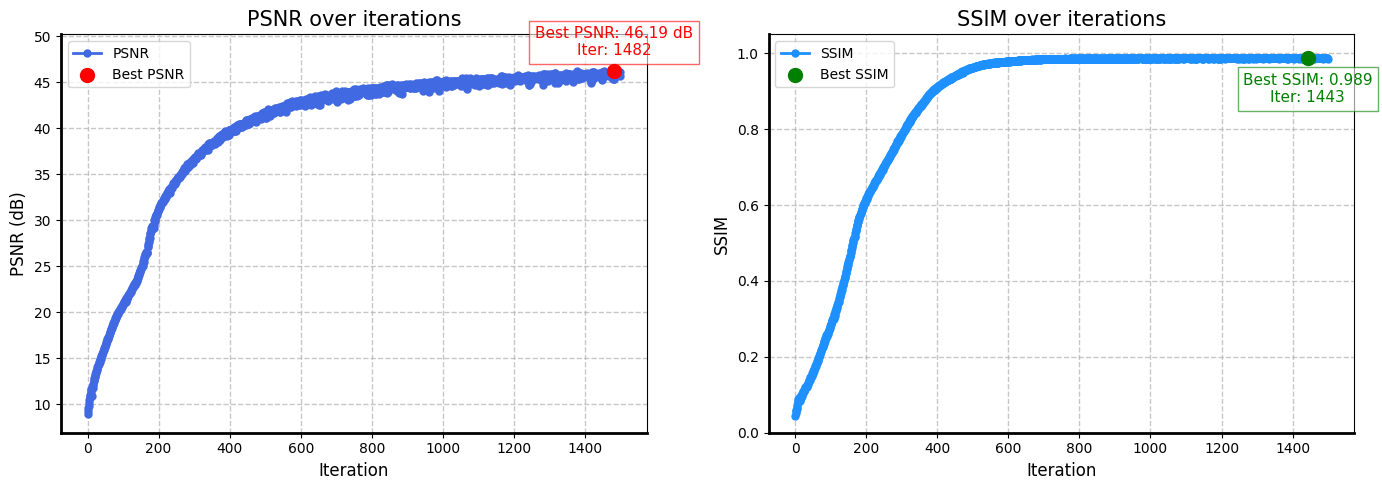

In [21]:
# Multimodal Deep Image Prior (DIP)

import os, io, copy
from typing import Optional, List
from PIL import Image
from google.colab import files

import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import cv2
from skimage.metrics import peak_signal_noise_ratio as sk_psnr
from skimage.metrics import structural_similarity as sk_ssim

# ------------------------ Settings ------------------------
TARGET_SIZE = 256
NUM_ITER = 1500
LR = 1e-3
TV_WEIGHT = 1e-5
INPUT_DEPTH = 32
SHOW_EVERY = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ------------------------ Utilities ------------------------
def pil_to_np(img_pil, size=TARGET_SIZE):
    img = img_pil.convert("RGB").resize((size, size), Image.LANCZOS)
    return np.array(img)

def np_to_tensor(img_np):
    return torch.from_numpy(img_np.astype(np.float32)/255.0).permute(2,0,1).unsqueeze(0)

def tensor_to_np(t):
    t = t.detach().cpu().squeeze(0).clamp(0,1).numpy()
    t = np.transpose(t, (1,2,0))
    return (t * 255).astype(np.uint8)

def compute_metrics_np(A, B):
    if A.ndim == 3:
        A = cv2.cvtColor(A, cv2.COLOR_RGB2GRAY)
    if B.ndim == 3:
        B = cv2.cvtColor(B, cv2.COLOR_RGB2GRAY)
    return sk_psnr(A, B, data_range=255), sk_ssim(A, B, data_range=255)

# ------------------------ U-Net ------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.block(x)

class AdaptiveUNet(nn.Module):
    def __init__(self, in_ch, out_ch=3, base=32, depth=4):
        super().__init__()
        self.down, self.pool, self.enc = nn.ModuleList(), nn.ModuleList(), []

        ch = in_ch
        for i in range(depth):
            out = base * (2**i)
            self.down.append(DoubleConv(ch, out))
            self.pool.append(nn.AvgPool2d(2))
            self.enc.append(out)
            ch = out

        self.bottleneck = DoubleConv(ch, ch*2)
        ch *= 2

        self.up, self.dec = nn.ModuleList(), nn.ModuleList()
        for skip_ch in reversed(self.enc):
            self.up.append(nn.ConvTranspose2d(ch, skip_ch, 2, stride=2))
            self.dec.append(DoubleConv(skip_ch*2, skip_ch))
            ch = skip_ch

        self.final = nn.Conv2d(ch, out_ch, 1)

    def forward(self, x):
        skips = []
        out = x

        for d,p in zip(self.down, self.pool):
            out = d(out)
            skips.append(out)
            out = p(out)

        out = self.bottleneck(out)

        for up,dec in zip(self.up,self.dec):
            out = up(out)
            skip = skips.pop()

            if out.shape[-2:] != skip.shape[-2:]:
                out = F.interpolate(out, size=skip.shape[-2:])

            out = torch.cat([skip, out], dim=1)
            out = dec(out)

        return torch.sigmoid(self.final(out))

# ------------------------ Sobel Edge Loss ------------------------
def create_sobel():
    sobel_x = torch.tensor([[[[-1,0,1],[-2,0,2],[-1,0,1]]]], dtype=torch.float32).to(device)
    sobel_y = torch.tensor([[[[-1,-2,-1],[0,0,0],[1,2,1]]]], dtype=torch.float32).to(device)

    sobel_x = sobel_x.repeat(3,1,1,1)
    sobel_y = sobel_y.repeat(3,1,1,1)
    return sobel_x, sobel_y

sobx, soby = create_sobel()

def edges(img):
    gx = F.conv2d(img, sobx, padding=1, groups=3)
    gy = F.conv2d(img, soby, padding=1, groups=3)
    return torch.sqrt(gx*gx + gy*gy + 1e-8)

# ------------------------ DIP Training ------------------------
def dip_train_multimodal(target_np, aux_list):

    H,W,_ = target_np.shape
    target_t = np_to_tensor(target_np).to(device)

    aux_cat = torch.cat([np_to_tensor(a).to(device) for a in aux_list], dim=1)

    z = torch.randn(1, INPUT_DEPTH, H, W, device=device) * 0.1
    in_ch = INPUT_DEPTH + aux_cat.shape[1]

    net = AdaptiveUNet(in_ch, 3).to(device)
    opt = optim.Adam(net.parameters(), lr=LR)

    best_psnr = -1e9
    best_out = None

    loss_hist = []
    psnr_hist = []
    ssim_hist = []

    for i in trange(NUM_ITER):

        opt.zero_grad()
        inp = torch.cat([z, aux_cat], dim=1)
        out = net(inp)

        mse = F.mse_loss(out, target_t)
        identity = F.l1_loss(out, target_t)
        ed = F.l1_loss(edges(out), edges(target_t))

        tv = (torch.abs(out[:,:,1:,:]-out[:,:,:-1,:]).mean() +
              torch.abs(out[:,:,:,1:]-out[:,:,:,:-1]).mean())

        loss = (
            1.0*mse +
            0.3*identity +
            0.5*ed +
            TV_WEIGHT*tv
        )

        loss.backward()
        opt.step()

        loss_hist.append(loss.item())

        # Metrics tracking
        out_np = tensor_to_np(out)
        cur_psnr, cur_ssim = compute_metrics_np(target_np, out_np)

        psnr_hist.append(cur_psnr)
        ssim_hist.append(cur_ssim)

        if cur_psnr > best_psnr:
            best_psnr = cur_psnr
            best_out = out.detach().cpu()

        if i % SHOW_EVERY == 0:
            print(f"Iter {i}/{NUM_ITER} | PSNR: {cur_psnr:.2f}")

    return tensor_to_np(best_out), loss_hist, psnr_hist, ssim_hist

# ------------------------ Main ------------------------
def main():

    print("Upload Modality A (target)")
    Afile = files.upload()
    A_np = pil_to_np(Image.open(io.BytesIO(next(iter(Afile.values())))))

    print("Upload Modality B (aux guidance)")
    Bfile = files.upload()
    B_np = pil_to_np(Image.open(io.BytesIO(next(iter(Bfile.values())))))

    # Run DIP
    restored_np, loss_hist, psnr_hist, ssim_hist = dip_train_multimodal(A_np, [B_np])

    A_vs_B = compute_metrics_np(A_np, B_np)
    A_vs_Out = compute_metrics_np(A_np, restored_np)

    PSNR_improve = A_vs_Out[0] - A_vs_B[0]
    SSIM_improve = A_vs_Out[1] - A_vs_B[1]

    # ---------------- METRIC SUMMARY ----------------
    print("\n=========== FINAL METRICS AFTER DIP ===========")
    print(f"PSNR (A → DIP): {A_vs_Out[0]:.2f} dB")
    print(f"SSIM (A → DIP): {A_vs_Out[1]:.4f}")
    print("\n----- IMPROVEMENT SUMMARY -----")
    print(f"PSNR Improvement: {PSNR_improve:.2f} dB")
    print(f"SSIM Improvement: {SSIM_improve:.4f}")
    print("==============================================\n")

    # ---------------- IMAGE DISPLAY ----------------
    fig, axs = plt.subplots(1,3, figsize=(18,6))

    axs[0].imshow(A_np)
    axs[0].set_title(f"Modality A\nPSNR(A-B): {A_vs_B[0]:.2f} | SSIM: {A_vs_B[1]:.3f}")
    axs[0].axis("off")

    axs[1].imshow(B_np)
    axs[1].set_title(f"Modality B\nPSNR(A-Out): {A_vs_Out[0]:.2f} | SSIM: {A_vs_Out[1]:.3f}")
    axs[1].axis("off")

    axs[2].imshow(restored_np)
    axs[2].set_title(f"DIP Output\nPSNR Gain: {PSNR_improve:.2f} dB")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

    # ---------------- TRAINING LOSS GRAPH ----------------
    plt.figure(figsize=(8,4))
    plt.plot(loss_hist, linewidth=1.5)
    plt.title("Training Loss (MSE + TV + Identity + Edge)")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # ---------------- IMPROVED PSNR + SSIM GRAPHS ----------------
    plt.figure(figsize=(14,5))

    # Prepare x-axis (iterations)
    iterations = list(range(len(psnr_hist)))

    # -------------------------------------------------
    #                PSNR PLOT WITH BEST MARKER
    # -------------------------------------------------
    ax1 = plt.subplot(1,2,1)
    ax1.plot(iterations, psnr_hist, marker='o', markersize=5, linewidth=2, color='royalblue', label='PSNR')
    ax1.set_title("PSNR over iterations", fontsize=15)
    ax1.set_xlabel("Iteration", fontsize=12)
    ax1.set_ylabel("PSNR (dB)", fontsize=12)
    ax1.grid(True, linestyle='--', linewidth=1, alpha=0.7)

    # Best PSNR
    best_psnr_value = max(psnr_hist)
    best_psnr_iter = int(np.argmax(psnr_hist))

    # Highlight best PSNR point
    ax1.scatter(best_psnr_iter, best_psnr_value, color='red', s=100, zorder=5, label='Best PSNR')
    ax1.text(best_psnr_iter, best_psnr_value + (0.03*best_psnr_value),
             f"Best PSNR: {best_psnr_value:.2f} dB\nIter: {best_psnr_iter}",
             fontsize=11, color='red', ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.6, edgecolor='red'))

    ax1.set_ylim(min(psnr_hist) - 2, max(psnr_hist) + 4)
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['bottom'].set_linewidth(2)
    ax1.legend()

    # -------------------------------------------------
    #                SSIM PLOT WITH BEST MARKER
    # -------------------------------------------------
    ax2 = plt.subplot(1,2,2)
    ax2.plot(iterations, ssim_hist, marker='o', markersize=5, linewidth=2, color='dodgerblue', label='SSIM')
    ax2.set_title("SSIM over iterations", fontsize=15)
    ax2.set_xlabel("Iteration", fontsize=12)
    ax2.set_ylabel("SSIM", fontsize=12)
    ax2.grid(True, linestyle='--', linewidth=1, alpha=0.7)

    # Best SSIM
    best_ssim_value = max(ssim_hist)
    best_ssim_iter = int(np.argmax(ssim_hist))

    ax2.scatter(best_ssim_iter, best_ssim_value, color='green', s=100, zorder=5, label='Best SSIM')
    ax2.text(best_ssim_iter, best_ssim_value - 0.04,
             f"Best SSIM: {best_ssim_value:.3f}\nIter: {best_ssim_iter}",
             fontsize=11, color='green', ha='center', va='top', bbox=dict(facecolor='white', alpha=0.6, edgecolor='green'))

    ax2.set_ylim(0, 1.05)
    ax2.spines['left'].set_linewidth(2)
    ax2.spines['bottom'].set_linewidth(2)
    ax2.legend()

    plt.tight_layout()
    plt.show()

# RUN
main()


In [38]:
#VIDEO DIP

In [39]:
!pip install imageio[pyav]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 31.1 MB/s eta 0:00:00


Device: cuda
Upload a video file:


Saving vid2.mp4 to vid2.mp4
Training DIP for clarity…


100%|██████████| 2000/2000 [00:45<00:00, 44.08it/s]


Best clarity at 1500 | PSNR=19.5891
    frame       PSNR      SSIM
0       0  15.014570  0.414256
1       1  15.127528  0.415593
2       2  15.046933  0.407083
3       3  15.033864  0.396946
4       4  15.084605  0.391260
5       5  15.094057  0.390486
6       6  15.097194  0.389107
7       7  15.007245  0.385118
8       8  15.007572  0.384156
9       9  15.003246  0.383112
10     10  15.031224  0.383056
11     11  15.008628  0.381587
12     12  14.890710  0.377736
13     13  17.103996  0.198626
14     14  17.088423  0.191921
15     15  17.093395  0.191034
16     16  17.070896  0.190486
17     17  17.062036  0.189366
18     18  17.018688  0.186997
19     19  17.046430  0.190369
20     20  17.007188  0.189247
21     21  17.010231  0.188847
22     22  17.044608  0.191880
23     23  17.031100  0.193401
24     24  17.022819  0.192601
25     25  17.025764  0.193437
26     26  17.053962  0.195287
27     27  17.031443  0.194143
28     28  17.045464  0.195467
29     29  17.032008  0.195124
30 

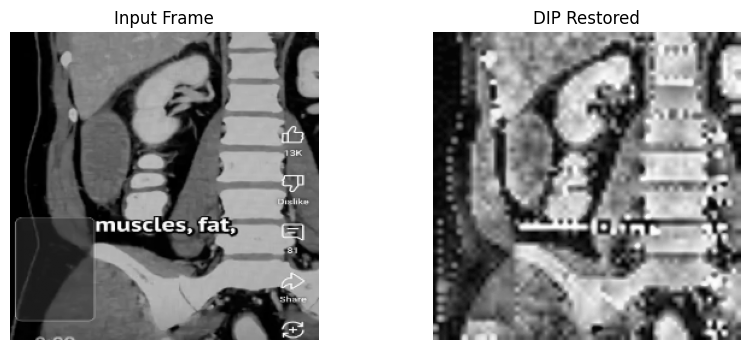

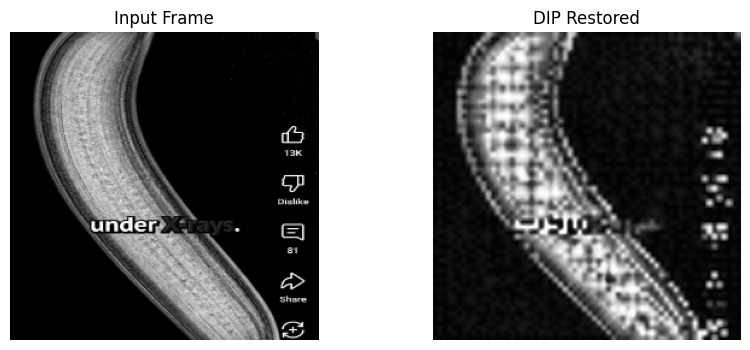

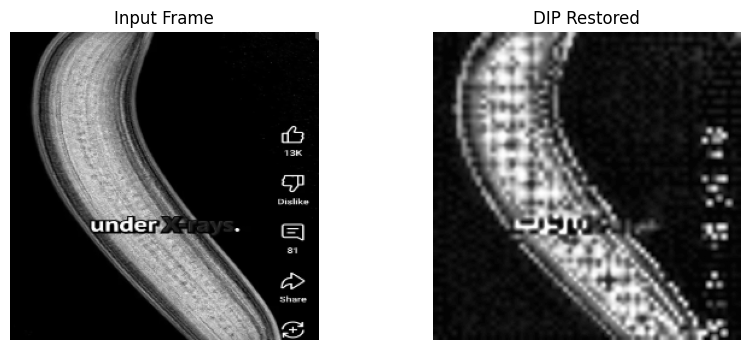

Done! All outputs saved.


In [48]:
# ============================
# HIGH-CLARITY VIDEO DIP (v4)
# ============================
# ✔ Fixed Sobel filter syntax error
# ✔ 2000 iterations for clarity
# ✔ Stronger edge loss
# ✔ Optional sharpening
# ✔ Full PSNR + SSIM
# ✔ Stable output
# ========================================

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import imageio.v3 as iio
from tqdm import trange
from google.colab import files
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as sk_psnr
from skimage.metrics import structural_similarity as sk_ssim
import pandas as pd

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

MAX_FRAMES = 40
SIZE = 256
Z_DIM = 64
BASE = 32

LR = 1e-3
ITER = 2000
EDGE_WEIGHT = 1.0
TV_WEIGHT = 5e-5

OUT_DIR = "dip_video_out_v4"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------- Upload video ----------------
print("Upload a video file:")
uploaded = files.upload()
video_path = list(uploaded.keys())[0]

# ---------------- Extract frames ----------------
def extract_frames(path, max_frames=MAX_FRAMES, size=SIZE):
    frames=[]
    for idx, frame in enumerate(iio.imiter(path, plugin="pyav")):
        if idx >= max_frames: break
        arr=np.array(frame)
        if arr.ndim==3:
            arr=cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
        arr=cv2.resize(arr,(size,size))
        frames.append(arr.astype(np.float32)/255.)
    return np.stack(frames,axis=0)

frames_np=extract_frames(video_path)
T,H,W=frames_np.shape
frames_t=torch.tensor(frames_np).unsqueeze(0).unsqueeze(0).float().to(DEVICE)

# Add slight noise (DIP needs this)
noisy=(frames_t+0.01*torch.randn_like(frames_t)).clamp(0,1)

# ---------------- FIXED SOBEL EDGE ----------------
sobel_x = torch.tensor(
    [[[-1,0,1],[-2,0,2],[-1,0,1]]],
    dtype=torch.float32, device=DEVICE
).unsqueeze(0)

sobel_y = torch.tensor(
    [[[-1,-2,-1],[0,0,0],[1,2,1]]],
    dtype=torch.float32, device=DEVICE
).unsqueeze(0)

def sobel_edges(x):
    B,C,T,H,W=x.shape
    flat=x.permute(0,2,1,3,4).reshape(B*T,C,H,W)
    gx=F.conv2d(flat,sobel_x,padding=1)
    gy=F.conv2d(flat,sobel_y,padding=1)
    mag=torch.sqrt(gx*gx+gy*gy+1e-8)
    return mag.view(B,T,1,H,W).permute(0,2,1,3,4)

# ---------------- DIP MODEL ----------------
class DIP3D(nn.Module):
    def __init__(self,T,H,W,z_dim=64,base=32):
        super().__init__()
        self.T=T; self.H=H; self.W=W
        sh=max(4,H//8); sw=max(4,W//8)
        self.sh=sh; self.sw=sw

        self.fc=nn.Linear(z_dim,base*sh*sw)
        self.conv1=nn.Conv3d(base,base,3,padding=1)
        self.down=nn.Conv3d(base,base*2,(1,3,3),stride=(1,2,2),padding=(0,1,1))
        self.conv2=nn.Conv3d(base*2,base*2,3,padding=1)
        self.bottleneck=nn.Conv3d(base*2,base*2,3,padding=1)
        self.up1=nn.ConvTranspose3d(base*2,base,(1,4,4),stride=(1,2,2),padding=(0,1,1))
        self.up2=nn.ConvTranspose3d(base,1,(1,4,4),stride=(1,2,2),padding=(0,1,1))

    def forward(self,z):
        B,T,D=z.shape
        x=self.fc(z.reshape(B*T,D))
        x=x.view(B,T,-1,self.sh,self.sw).permute(0,2,1,3,4)

        x=F.relu(self.conv1(x))
        x=F.relu(self.down(x))
        x=F.relu(self.conv2(x))
        x=F.relu(self.bottleneck(x))
        x=F.relu(self.up1(x))
        x=torch.sigmoid(self.up2(x))

        BT,C,Hs,Ws = x.shape[0]*x.shape[2], x.shape[1], x.shape[3], x.shape[4]
        flat=x.permute(0,2,1,3,4).reshape(B*T,C,Hs,Ws)
        flat=F.interpolate(flat,size=(self.H,self.W),mode="bilinear")

        return flat.view(B,T,C,self.H,self.W).permute(0,2,1,3,4)

model=DIP3D(T,H,W,z_dim=Z_DIM,base=BASE).to(DEVICE)

# ---------------- Train ----------------
z=torch.randn(1,T,Z_DIM,device=DEVICE,requires_grad=True)
opt=optim.Adam(list(model.parameters())+[z],lr=LR)

best_psnr=-1
best_out=None
best_iter=0

print("Training DIP for clarity…")
for it in trange(ITER):
    opt.zero_grad()
    pred=model(z)

    loss1=F.mse_loss(pred,noisy)
    loss2=EDGE_WEIGHT*F.l1_loss(sobel_edges(pred),sobel_edges(noisy))
    loss3=TV_WEIGHT*(torch.abs(pred[:,:,:,1:,:]-pred[:,:,:,:-1,:]).mean()+torch.abs(pred[:,:,:,:,1:]-pred[:,:,:,:,:-1]).mean())

    loss=loss1+loss2+loss3
    loss.backward()
    opt.step()

    # Track best PSNR using mid frame
    if it%50==0 or it==ITER-1:
        mid=T//2
        clean=frames_np[mid]
        restored=pred[0,0,mid].detach().cpu().numpy()
        ps=sk_psnr(clean,restored,data_range=1.0)

        if ps>best_psnr:
            best_psnr=ps
            best_out=pred.detach().cpu().clone()
            best_iter=it

print(f"Best clarity at {best_iter} | PSNR={best_psnr:.4f}")

# ---------------- Final Output ----------------
out_np=best_out.squeeze().numpy()

# Optional CLAHE sharpening
clahe=cv2.createCLAHE(clipLimit=3.0,tileGridSize=(8,8))
out_sharp=[clahe.apply((f*255).astype(np.uint8))/255. for f in out_np]
out_sharp=np.stack(out_sharp)

# ---------------- Metrics ----------------
rows=[]
for i in range(T):
    ps=sk_psnr(frames_np[i],out_sharp[i],data_range=1.0)
    ss=sk_ssim(frames_np[i],out_sharp[i],data_range=1.0)
    rows.append({"frame":i,"PSNR":ps,"SSIM":ss})

df=pd.DataFrame(rows)
print(df)
print("\nAverage PSNR:",df["PSNR"].mean())
print("Average SSIM:",df["SSIM"].mean())

df.to_csv(f"{OUT_DIR}/metrics.csv",index=False)

# ---------------- Show samples ----------------
for idx in [0,T//2,T-1]:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(frames_np[idx],cmap="gray"); plt.title("Input Frame"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(out_sharp[idx],cmap="gray"); plt.title("DIP Restored"); plt.axis("off")
    plt.show()

print("Done! All outputs saved.")
